## GPR with Proper Parameter Wrangling

Authors: Sofia Ingersoll & Daniel Kennedy

#### Set Up

In [2]:
# import libraries & data pre-processing functions from utils.py
import xarray as xr
import os

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, Matern, ConstantKernel, RationalQuadratic, ExpSineSquared
from sklearn.metrics.pairwise import linear_kernel as Linear
from sklearn.metrics.pairwise import polynomial_kernel as Polynomial

from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from scipy.stats import norm


from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from ml_utils import *

In [3]:
# Request an additional 100 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 30)

# apply peer2peer network communication across multiple devices
client.cluster

/glade/u/home/hmchilders/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35427 instead
  warnings.warn(


Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hmchilders/proxy/35427/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.91:40541,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hmchilders/proxy/35427/status,Total threads: 0
Started: Just now,Total memory: 0 B


####  Read & Wrangle

In [4]:
def param_wrangling():
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        Parameter Data.       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # x parameter data for assessment
    df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
    # the only dimension here is the 'member' aka file index id [LCH0001-500]
    # convert to xr.ds
    params = xr.Dataset(df)

    # list comprehension no need for empty list
    columns = [params[v].values for v in params.data_vars]

    # iterate over params
    return np.array(columns).T

In [6]:
param = param_wrangling()

In [34]:
var = subset_var_cluster('LNC')
var = wrangle_var_cluster(var)

In [18]:
df.columns

Index(['FUN_fracfixers', 'KCN', 'a_fix', 'crit_dayl', 'd_max', 'fff',
       'froot_leaf', 'fstor2tran', 'grperc', 'jmaxb0', 'jmaxb1', 'kcha',
       'kmax', 'krmax', 'leaf_long', 'leafcn', 'lmr_intercept_atkin', 'lmrha',
       'lmrhd', 'medlynintercept', 'medlynslope', 'nstem', 'psi50', 'q10_mr',
       'slatop', 'soilpsi_off', 'stem_leaf', 'sucsat_sf', 'theta_cj',
       'tpu25ratio', 'tpuse_sf', 'wc2wjb0'],
      dtype='object')

In [8]:
var2 = subset_var_cluster('GPP')
var2 = wrangle_var_cluster(var2)

In [25]:
# x parameter data for assessment
df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
    
print(f"leafcn vs LNC:{np.corrcoef(df['leafcn'].values, var)[0,1]**2}")

print(f"leafcn vs GPP:{np.corrcoef(df['leafcn'].values, var2)[0,1]**2}")

leafcn vs LNC:0.7132633954375798
leafcn vs GPP:0.22455180335366112


#### Train Emulator

In [35]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# data for splitting
X_train, X_test, y_train, y_test = train_test_split(param,
                                                    var,
                                                    test_size=0.2,
                                                   # setting a seed
                                                    random_state=0)

In [18]:
X_train.shape

(400, 32)

In [36]:
gpr_model = GaussianProcessRegressor(normalize_y=True)

In [37]:
gpr_model.fit(X_train, y_train)

GaussianProcessRegressor(normalize_y=True)

In [38]:
y_pred, y_std = gpr_model.predict(X_test, return_std=True)

In [39]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Collect Metrics      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Calculate R^2
r2_train = r2_score(y_test, y_pred)
# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

# Create a DataFrame to store the results for plotting
results_df = pd.DataFrame({
     'y_pred': y_pred,
    'y_std': y_std,
    'y_test': y_test,
    'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
})

# Add metrics to the DataFrame
results_df['R^2'] = r2_train
results_df['RMSE'] = rmse_train
results_df['Mean Absolute Error'] = mae
    
# Print Training Metrics
print("Training R^2:", r2_train)
print("Training RMSE:", rmse_train)
print("Mean Absolute Error:", mae)

Training R^2: 0.8566417596520127
Training RMSE: 0.0731954621039928
Mean Absolute Error: 0.054532036803079185


In [40]:
X_test.shape

(100, 32)

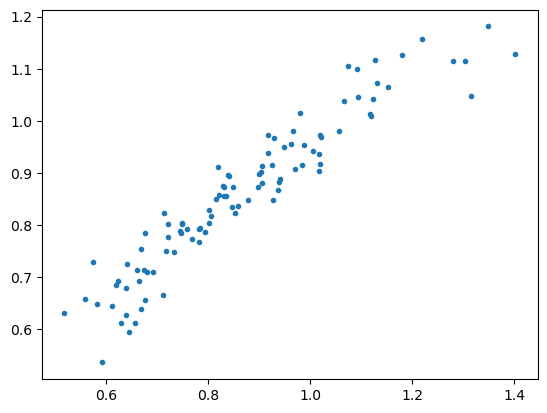

In [32]:
plt.plot(y_test, y_pred, ".")

In [39]:
y_std.shape

(100,)

In [46]:
X_test.shape

(100, 32)

#### Visualizing

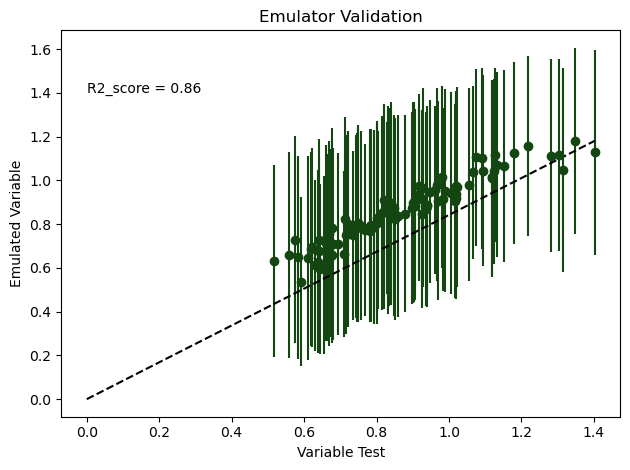

In [41]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Visualize Accuracy      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Code taken from Linnia to build off of, tweaked for y_test v y_pred
    # plot validation
   # y_pred, y_pred_var = gp_model.predict(X_test)
    #sd = y_pred_var.numpy().flatten()**0.5
    
coef_deter = r2_score(y_test,y_pred)
    
plt.errorbar(y_test,
                 y_pred,
                 yerr=3*y_std,
                 fmt="o",
                 color='#134611')
    
plt.text(0,np.max(y_test),
            'R2_score = '+str(np.round(coef_deter,2)),
            fontsize=10)
    
plt.plot([0,np.max(y_test)],
         [0,np.max(y_pred)],
          linestyle='--',
           c='k')
    
#plt.xlim([np.min(y_test)-1,np.max(y_test)+1])
#plt.ylim([np.min(y_pred)-1,np.max(y_pred)+1])

plt.xlabel('Variable Test')
plt.ylabel('Emulated Variable')
plt.title('Emulator Validation')
    
plt.tight_layout()

This needs tweaking because X_test is not being called, so the R^2 is not totally accurate

We want to weigh the 31 unselected parameters to 0.5 and to predict using X_test for our plot

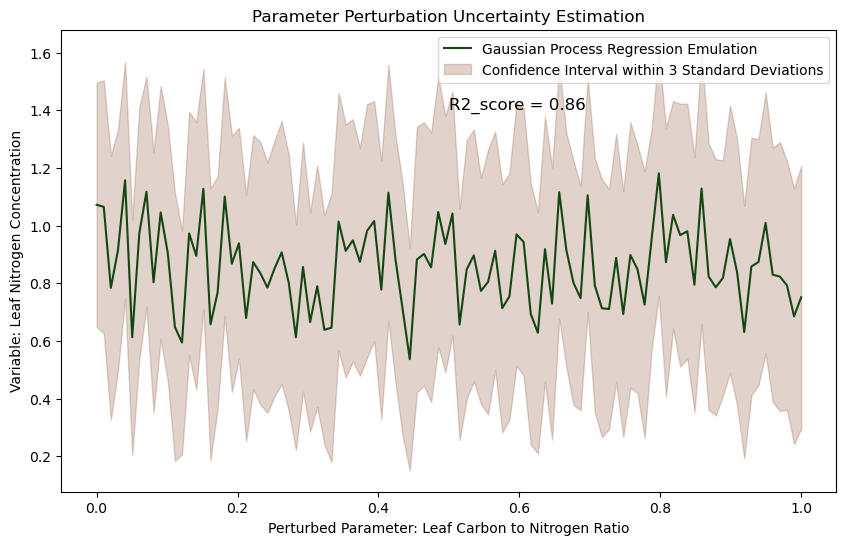

In [49]:
# Generate x_values with 32 dimensions
# Fill array with 0.5
X_values = np.full((100, 32), 0.5)  
# Set the 15th column values to evenly spaced values from 0 to 1
X_values[:, 15] = np.linspace(0, 1, 100)  

# Predict mean and standard deviation of the Gaussian process at each point in x_values
#y_pred, y_std = gpr_model.predict(X_values, return_std=True)

plt.figure(figsize=(10, 6))
# Plot the mean line
plt.plot(X_values[:, 15], y_pred, color='#134611', linestyle='-', label='Gaussian Process Regression Emulation')

# Calculate the z-score for the 99.7% confidence interval (three standard deviations)
z_score = norm.ppf(0.99865)  

# Plot the shaded region for three standard deviations
plt.fill_between(X_values[:, 15], y_pred - z_score * y_std, y_pred + z_score * y_std,
                 color='#9d6b53',
                 alpha=0.3,
                 label = 'Confidence Interval within 3 Standard Deviations')

plt.text(0.5, np.max(y_test),
            'R2_score = '+str(np.round(coef_deter,2)),
            fontsize=12)

plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
plt.ylabel('Variable: Leaf Nitrogen Concentration')
plt.title('Parameter Perturbation Uncertainty Estimation')

plt.legend()
plt.show()

#### leafcn vs GPP

In [50]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# data for splitting
X_train, X_test, y_train, y_test = train_test_split(param,
                                                    var2,
                                                    test_size=0.2,
                                                   # setting a seed
                                                    random_state=0)

gpr_model = GaussianProcessRegressor(normalize_y=True)

gpr_model.fit(X_train, y_train)

y_pred, y_std = gpr_model.predict(X_test, return_std=True)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Collect Metrics      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Calculate R^2
r2_train = r2_score(y_test, y_pred)
# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

# Create a DataFrame to store the results for plotting
results_df = pd.DataFrame({
     'y_pred': y_pred,
    'y_std': y_std,
    'y_test': y_test,
     'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
})

# Add metrics to the DataFrame
results_df['R^2'] = r2_train
results_df['RMSE'] = rmse_train
results_df['Mean Absolute Error'] = mae
    
# Print Training Metrics
print("Training R^2:", r2_train)
print("Training RMSE:", rmse_train)
print("Mean Absolute Error:", mae)

Training R^2: 0.74653039015835
Training RMSE: 3.54071238358866e-06
Mean Absolute Error: 2.5008176225625332e-06


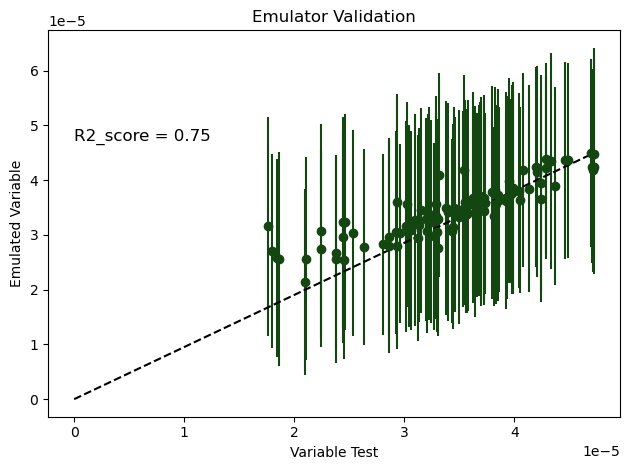

In [51]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Visualize Accuracy      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Code taken from Linnia to build off of, tweaked for y_test v y_pred
    # plot validation
   # y_pred, y_pred_var = gp_model.predict(X_test)
    #sd = y_pred_var.numpy().flatten()**0.5
    
coef_deter = r2_score(y_test,y_pred)
    
plt.errorbar(y_test,
                 y_pred,
                 yerr=3*y_std,
                 fmt="o",
                 color='#134611')
    
plt.text(0,np.max(y_test),
            'R2_score = '+str(np.round(coef_deter,2)),
            fontsize=12)
    
plt.plot([0,np.max(y_test)],
         [0,np.max(y_pred)],
          linestyle='--',
           c='k')
    
#plt.xlim([np.min(y_test)-1,np.max(y_test)+1])
#plt.ylim([np.min(y_pred)-1,np.max(y_pred)+1])

plt.xlabel('Variable Test')
plt.ylabel('Emulated Variable')
plt.title('Emulator Validation')
    
plt.tight_layout()

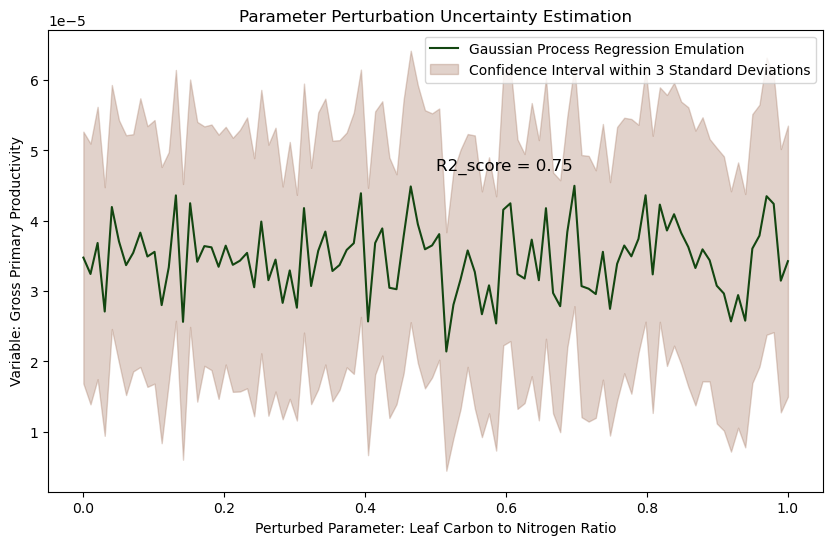

In [62]:
# Generate x_values with 32 dimensions
#Create an array that sets the value of all 32 parameters to 0.5
X_values = np.full((100, 32), 0.5)  # Fill array with 0.5
#For the parameter of interest, replace the 0.5 with a range of values between 0 and 1
X_values[:, 15] = np.linspace(0, 1, 100)  # Set the 15th column values to evenly spaced values from 0 to 1

# Predict mean and standard deviation of the Gaussian process at each point in x_values
#y_pred, y_std = gpr_model.predict(X_values, return_std=True)

plt.figure(figsize=(10, 6))
# Plot the mean line
plt.plot(X_values[:, 15], y_pred, color='#134611', linestyle='-', label='Gaussian Process Regression Emulation')

# Calculate the z-score for the 99.7% confidence interval
z_score = norm.ppf(0.99865)  # 99.7th percentile (three standard deviations)

    # Plot the shaded region for the 99.7% confidence interval with three standard deviations
plt.fill_between(X_values[:,15], y_pred - z_score * y_std, y_pred + z_score * y_std,
                 color='#9d6b53',
                 alpha=0.3,
                 label = 'Confidence Interval within 3 Standard Deviations')

plt.text(0.5, np.max(y_test),
            'R2_score = '+str(np.round(coef_deter,2)),
            fontsize=12)

plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
plt.ylabel('Variable: Gross Primary Productivity')
plt.title('Parameter Perturbation Uncertainty Estimation')

plt.legend()
plt.show()

In [16]:
X_test.shape

(100, 32)